In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

from unet import UNetModel
from diffusion import GaussianDiffusion

import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

## Load Data

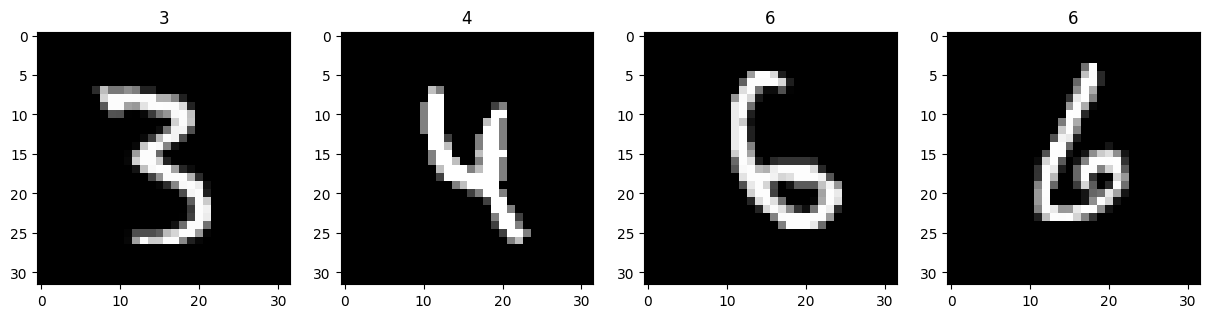

In [23]:
# Load MNIST dataset
device = torch.device('cuda:0')
batch_size = 128

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Pad(2),
    torchvision.transforms.Normalize(0.5, 0.5),
])
mnist_train = torchvision.datasets.MNIST(root='data/', train=True, transform=transforms, download=True)
data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

for batch in data_loader:
    img, labels = batch
    break
    
fig, ax = plt.subplots(1, 4, figsize=(15,15))
for i in range(4):
    ax[i].imshow(img[i,0,:,:].numpy())
    ax[i].set_title(str(labels[i].item()))
plt.show()

## Load Model

In [24]:
# Save/Load model
#torch.save(net.state_dict(), 'models/mnist_unet.pth')
#print('Saved model')

net = UNetModel(image_size=32, in_channels=1, out_channels=1, 
                model_channels=64, num_res_blocks=2, channel_mult=(1,2,3,4),
                attention_resolutions=[8,4], num_heads=4).to(device)
net.load_state_dict(torch.load('models/mnist_unet.pth'))
net.to(device)
net.train()
print('Loaded model')

Loaded model


/tmp/ipykernel_72800/1173412691.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('models/mnist_unet.pth'))


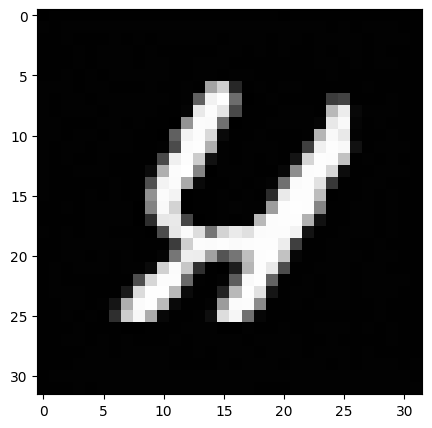

In [25]:
# Sample from the learned diffusion process
diffusion = GaussianDiffusion(T=1000, schedule='linear')

with torch.no_grad():
    net.eval()
    x = diffusion.inverse(net, shape=(1,32,32), device=device)
    net.train()

plt.figure(figsize=(5,5))
plt.imshow(x.cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
plt.show()

## Inference with hand-crafted conditions

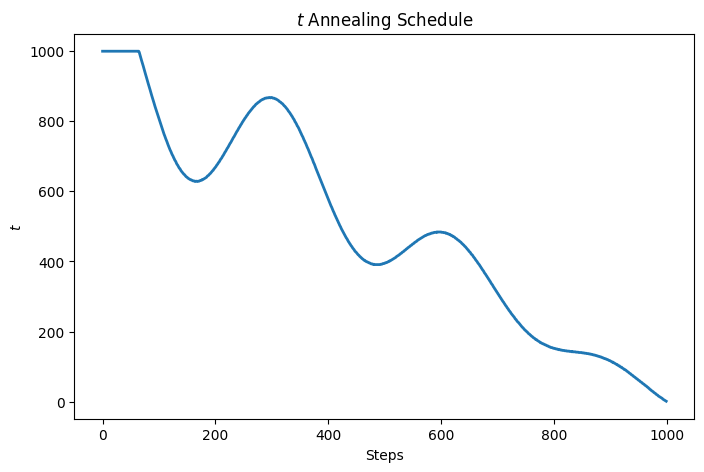

In [26]:
# Visualize t annealing schedule
diffusion = GaussianDiffusion(T=1000, schedule='linear')
steps = 1000

t_vals = []
for i in range(steps):
    t = ((steps-i) + (steps-i)//4*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t]).astype(int)
    t = np.clip(t, 1, diffusion.T)
    t_vals.append(t[0])
    
plt.figure(figsize=(8,5))
plt.plot(range(steps), t_vals, linewidth=2)
plt.title('$t$ Annealing Schedule')
plt.xlabel('Steps')
plt.ylabel('$t$')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s, Loss=0.00177]

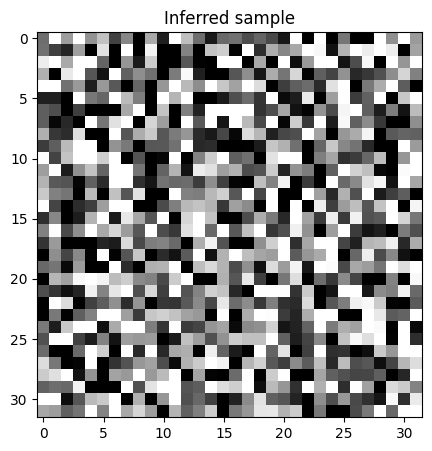

 10%|▉         | 99/1000 [00:05<00:50, 17.73it/s, Loss=0.00109]

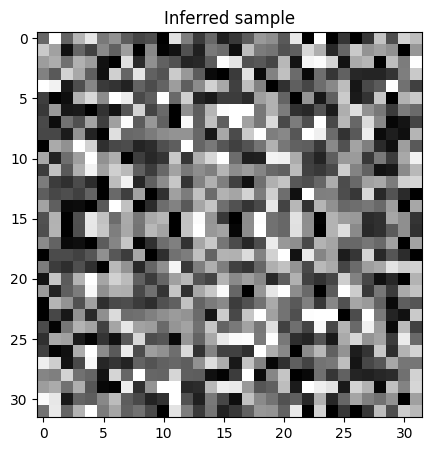

 20%|█▉        | 199/1000 [00:11<00:43, 18.55it/s, Loss=0.00257] 

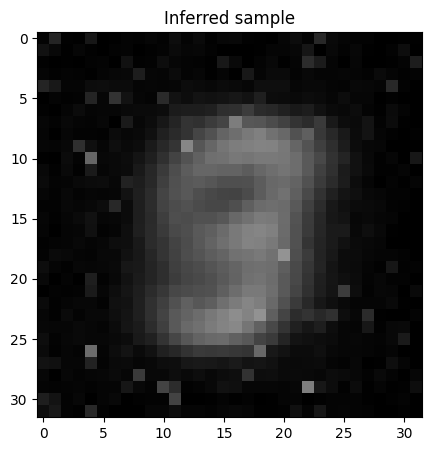

 30%|██▉       | 299/1000 [00:17<00:39, 17.91it/s, Loss=0.000225]

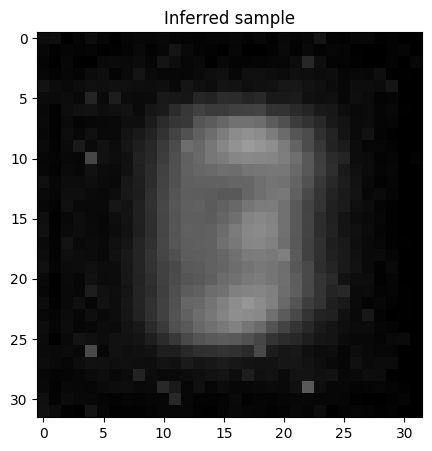

 40%|███▉      | 399/1000 [00:22<00:34, 17.62it/s, Loss=0.000139]

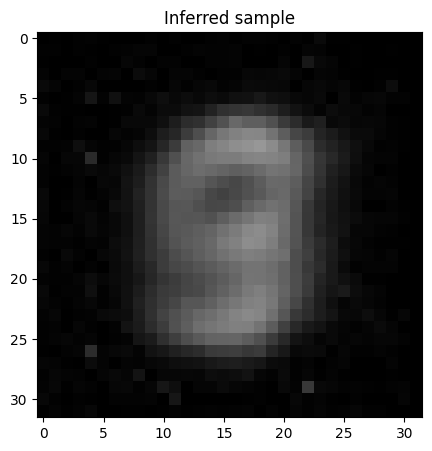

 50%|████▉     | 499/1000 [00:28<00:27, 18.14it/s, Loss=0.00488] 

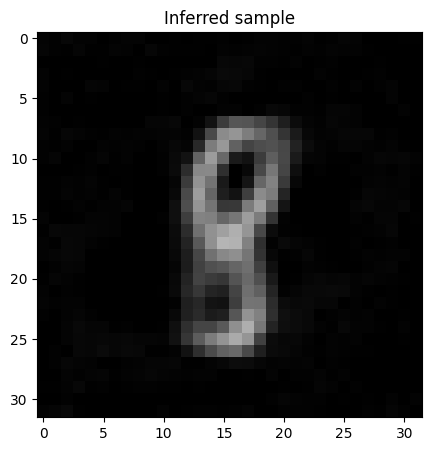

 60%|█████▉    | 599/1000 [00:34<00:22, 18.18it/s, Loss=0.00871]

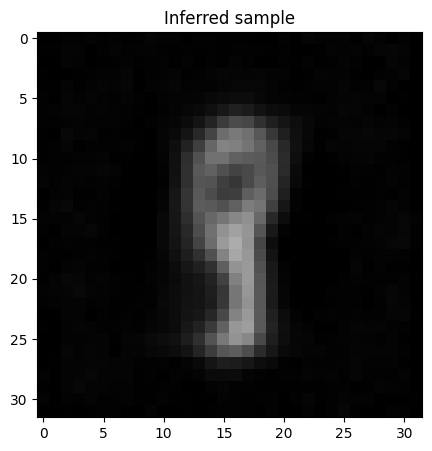

 70%|██████▉   | 699/1000 [00:40<00:17, 17.33it/s, Loss=0.00484]

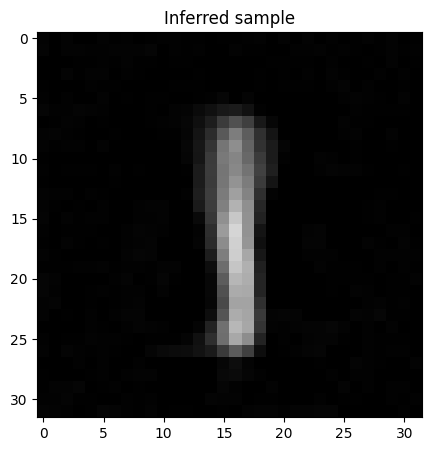

 80%|███████▉  | 799/1000 [00:45<00:11, 17.52it/s, Loss=0.00874]

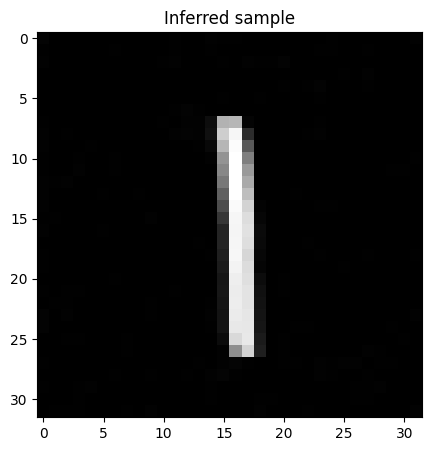

 90%|████████▉ | 899/1000 [00:51<00:05, 18.45it/s, Loss=0.00905]

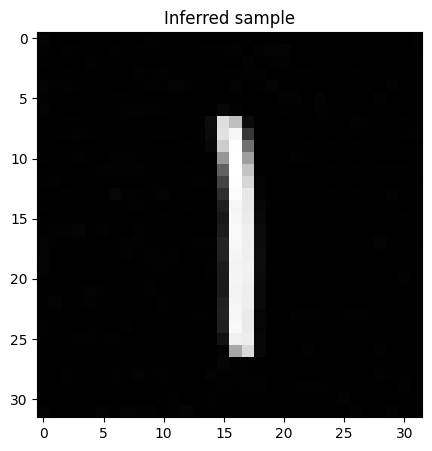

100%|█████████▉| 999/1000 [00:57<00:00, 17.41it/s, Loss=0.0122] 

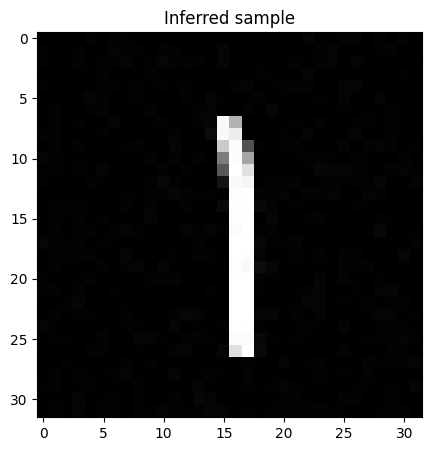

100%|██████████| 1000/1000 [00:58<00:00, 17.24it/s, Loss=0.0122]


In [27]:
# Inference Model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.img = nn.Parameter(torch.randn(1,1,32,32))
        self.img.requires_grad = True
                
    def encode(self):
        return self.img
    
model = Model().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
net.train()

steps = 1000
bar = tqdm.tqdm(range(steps))
losses = []
update_every = 50
for i, _ in enumerate(bar):
    sample_img = model.encode()
   
    # Select t
    t = ((steps-i) + (steps-i)//4*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t]).astype(int)
    t = np.clip(t, 1, diffusion.T)
    
    # Denoise
    xt, epsilon = diffusion.sample(sample_img, t)       
    t = torch.from_numpy(t).float().view(sample_img.shape[0])
    epsilon_pred = net(xt.float(), t.to(device))

    # Hand-crafted conditions
    sample_img_clipped = torch.clip(sample_img, -1, 1)
    #vertical_similarity = F.mse_loss(sample_img_clipped, torchvision.transforms.functional.hflip(model.encode()))
    horizontal_similarity = F.mse_loss(sample_img_clipped, torchvision.transforms.functional.vflip(model.encode()))
    #vertical_dissimilarity = -F.mse_loss(sample_img_clipped, torchvision.transforms.functional.hflip(sample_img_clipped))
    #horizontal_dissimilarity = -F.mse_loss(sample_img_clipped, torchvision.transforms.functional.vflip(sample_img_clipped))

    # Denoising loss + aux loss
    loss = F.mse_loss(epsilon_pred, epsilon) + 1e-3*(steps-i)/steps*horizontal_similarity
    
    # Update
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    if i % update_every == 0:
        bar.set_postfix({'Loss': np.mean(losses)})
        losses = []

    # Visualize sample
    if (i+1) % 100 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(model.encode()[0].detach().cpu().numpy().transpose([1,2,0]), vmin=-1, vmax=1)
            ax.set_title('Inferred sample')
            plt.show()

## Inference with a learned condition

Epoch [1/5]


100%|██████████| 469/469 [00:02<00:00, 176.70it/s, Loss=0.159]


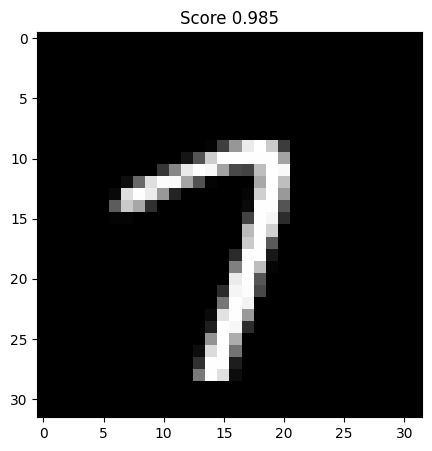

Epoch [2/5]


100%|██████████| 469/469 [00:02<00:00, 166.41it/s, Loss=0.0826]


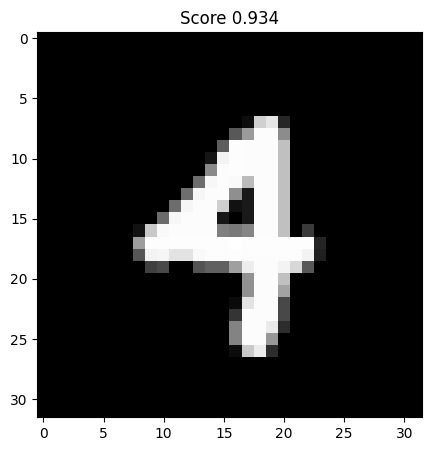

Epoch [3/5]


100%|██████████| 469/469 [00:02<00:00, 173.81it/s, Loss=0.0723]


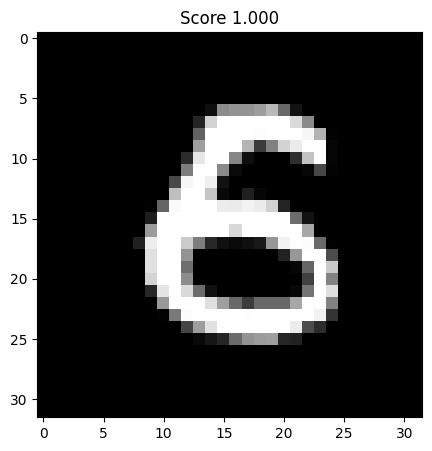

Epoch [4/5]


100%|██████████| 469/469 [00:02<00:00, 175.87it/s, Loss=0.0604]


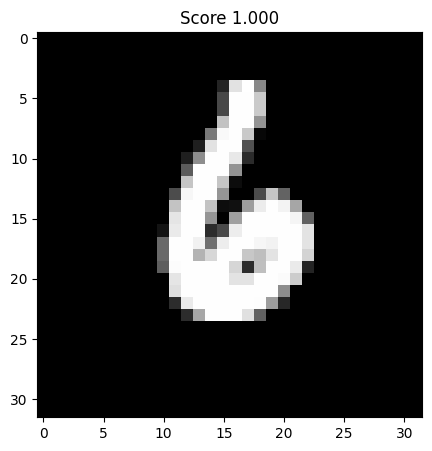

Epoch [5/5]


100%|██████████| 469/469 [00:02<00:00, 179.37it/s, Loss=0.0552]


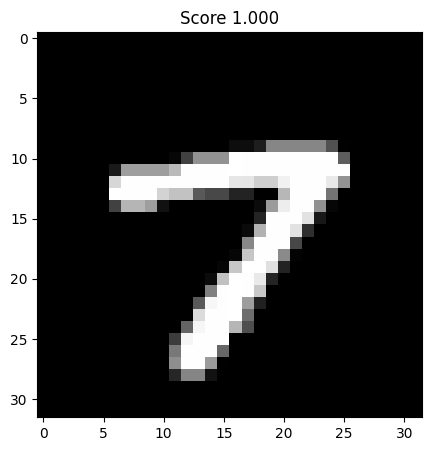

In [28]:
# Train classifier
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 2, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 2, 1)
        self.out = nn.Linear(4*4*32, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.out(x.flatten(1))
        
        return torch.sigmoid(x)
    
# Train network
class_net = Classifier().to(device)
class_opt = torch.optim.Adam(class_net.parameters(), lr=1e-4)

target_label = 3 # Digit to distinguish
epochs = 5
update_every = 100
for e in range(epochs):
    print(f'Epoch [{e+1}/{epochs}]')
    
    losses = []
    batch_bar = tqdm.tqdm(data_loader)
    for i, batch in enumerate(batch_bar):
        img, labels = batch
        
        labels = (labels != target_label).float().to(device)
        
        # Pass through network
        out = class_net(img.float().to(device))
        
        # Compute loss and backprop
        loss = F.binary_cross_entropy(out.squeeze(-1), labels)
        
        class_opt.zero_grad()
        loss.backward()
        class_opt.step()
        
        losses.append(loss.item())
        if i % update_every == 0:
            batch_bar.set_postfix({'Loss': np.mean(losses)})
            losses = []
            
    batch_bar.set_postfix({'Loss': np.mean(losses)})
    losses = []
    
    plt.figure(figsize=(5,5))
    plt.imshow(img.numpy()[0,0,:,:])
    plt.title(f'Score {out[0].item():.3f}')
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s, Loss=0.01]

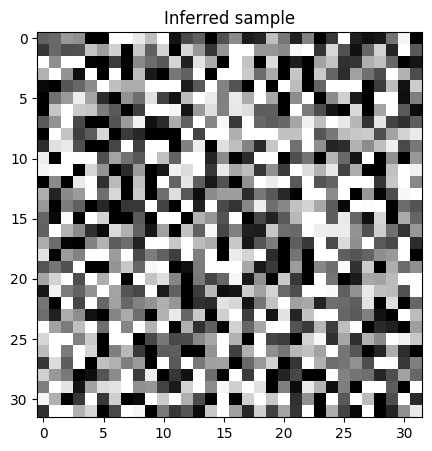

 10%|▉         | 99/1000 [00:06<00:54, 16.58it/s, Loss=0.00969]

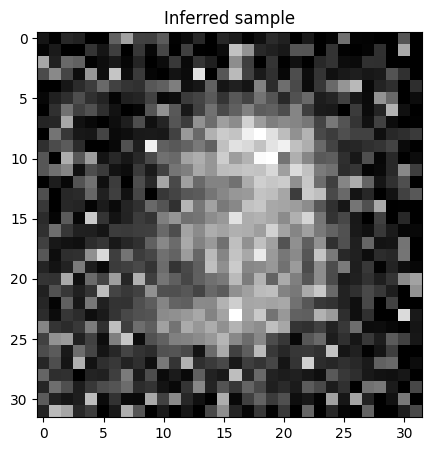

 20%|█▉        | 199/1000 [00:12<00:48, 16.55it/s, Loss=0.00102]

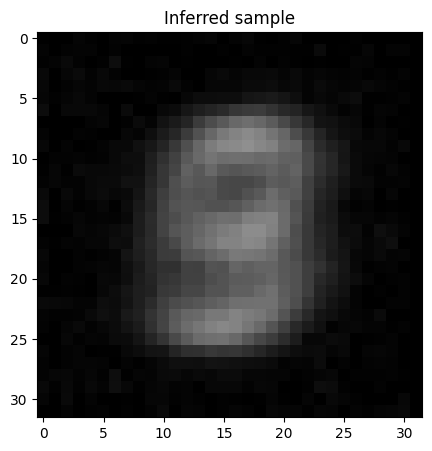

 30%|██▉       | 299/1000 [00:18<00:42, 16.56it/s, Loss=0.00135]

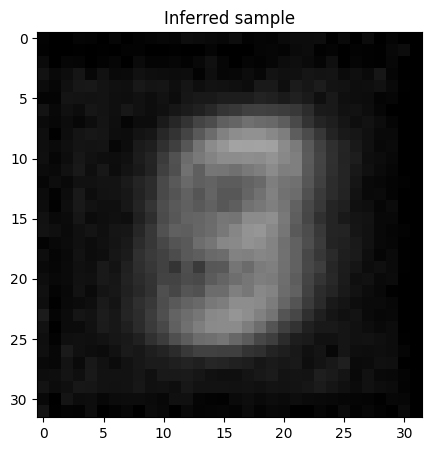

 40%|███▉      | 399/1000 [00:24<00:35, 16.83it/s, Loss=0.000679]

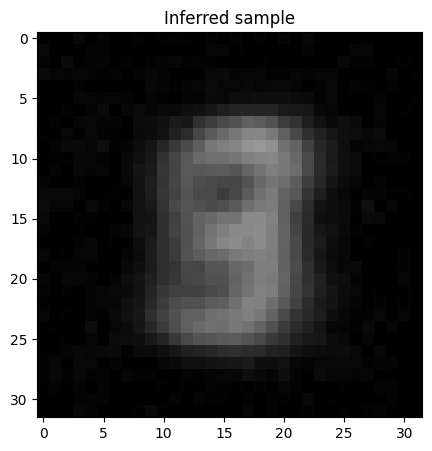

 50%|████▉     | 499/1000 [00:30<00:30, 16.21it/s, Loss=0.00206] 

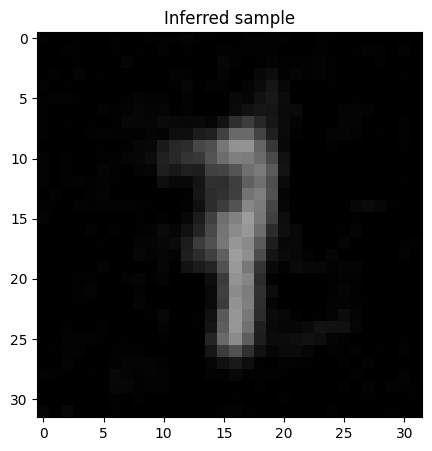

 60%|█████▉    | 599/1000 [00:36<00:23, 16.78it/s, Loss=0.00399]

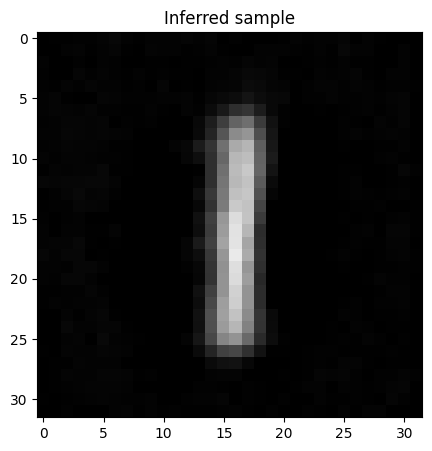

 70%|██████▉   | 699/1000 [00:43<00:19, 15.16it/s, Loss=0.00337]

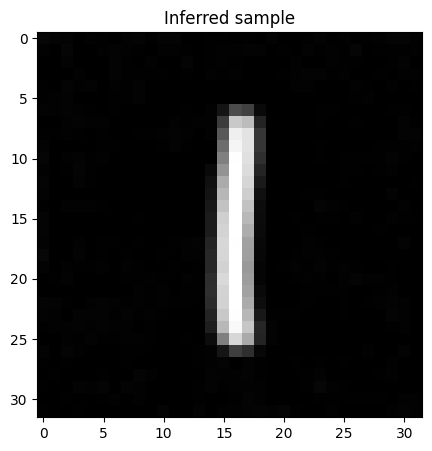

 80%|███████▉  | 799/1000 [00:49<00:12, 16.72it/s, Loss=0.0027] 

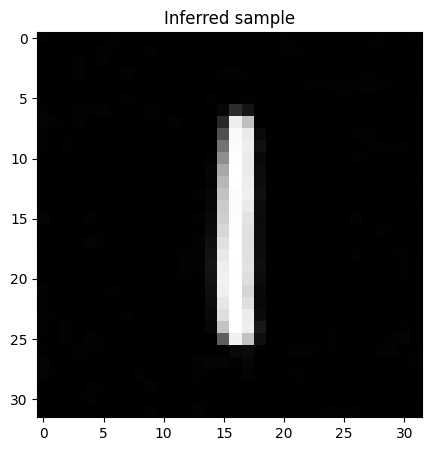

 90%|████████▉ | 899/1000 [00:55<00:06, 16.66it/s, Loss=0.00173]

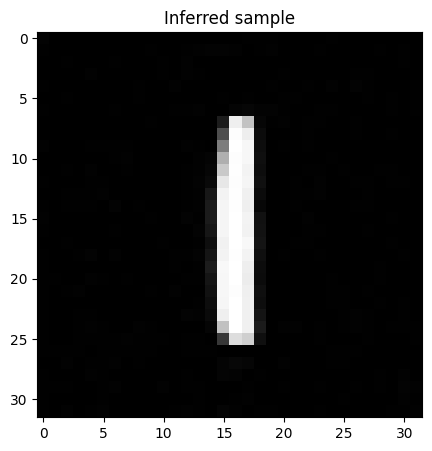

100%|█████████▉| 999/1000 [01:01<00:00, 17.18it/s, Loss=0.000741]

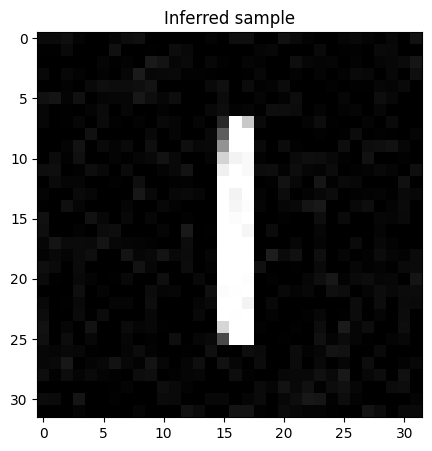

100%|██████████| 1000/1000 [01:01<00:00, 16.20it/s, Loss=0.000741]


In [31]:
# Inference Model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.img = nn.Parameter(torch.randn(1,1,32,32))
        self.img.requires_grad = True
                
    def encode(self):
        return self.img
    
model = Model().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
net.train()
class_net.train()

steps = 1000
bar = tqdm.tqdm(range(steps))
losses = []
update_every = 50
for i, _ in enumerate(bar):
    sample_img = model.encode()
   
    # Select t
    t = ((steps-i) + (steps-i)//4*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t]).astype(int)
    t = np.clip(t, 1, diffusion.T)
    
    # Denoise
    xt, epsilon = diffusion.sample(sample_img, t)       
    t = torch.from_numpy(t).float().view(sample_img.shape[0])
    epsilon_pred = net(xt.float(), t.to(device))

    loss = F.mse_loss(epsilon_pred, epsilon) 
    opt.zero_grad()
    loss.backward()

    with torch.no_grad():
        grad_norm = torch.linalg.norm(model.img.grad)
        if i > 0:
            alpha = 0.5
            norm_track = alpha*norm_track + (1-alpha)*grad_norm
        else:
            norm_track = grad_norm
    
    opt.step()

    # Learned condition
    sample_img_clipped = torch.clip(sample_img, -1, 1)
    class_loss = class_net(sample_img_clipped).mean()

    # Denoising loss + aux loss
    loss = 0.01*(steps-i)/steps*class_loss
    
    # Update
    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1*norm_track)
    opt.step()
    
    losses.append(loss.item())
    if i % update_every == 0:
        bar.set_postfix({'Loss': np.mean(losses)})
        losses = []

    # Visualize sample
    if (i+1) % 100 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(model.encode()[0].detach().cpu().numpy().transpose([1,2,0]), vmin=-1, vmax=1)
            ax.set_title('Inferred sample')
            plt.show()

## Inference with hand-crafted and learned conditions

  0%|          | 0/1000 [00:00<?, ?it/s, Loss=0.0102]

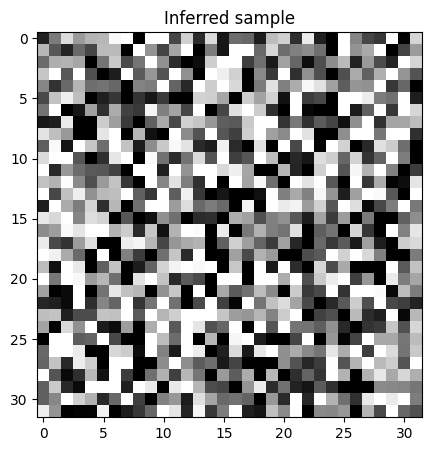

 10%|▉         | 98/1000 [00:06<00:53, 16.86it/s, Loss=0.00986]

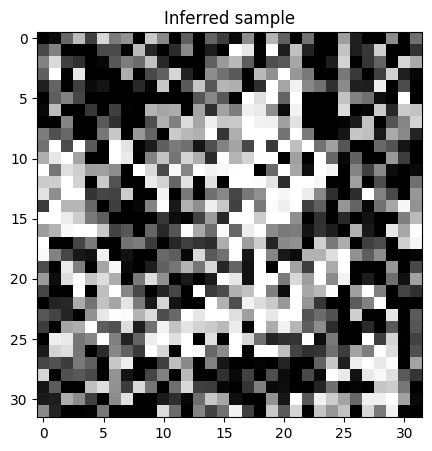

 20%|█▉        | 198/1000 [00:11<00:43, 18.29it/s, Loss=0.00394]

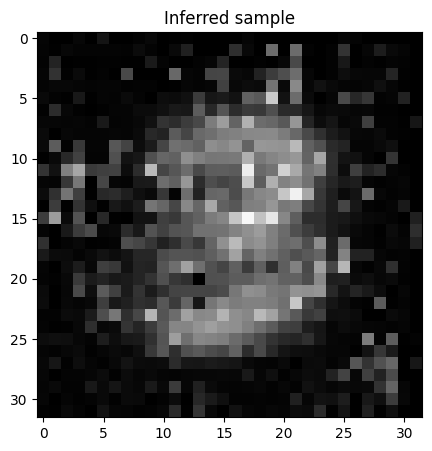

 30%|██▉       | 298/1000 [00:17<00:41, 16.92it/s, Loss=0.000477]

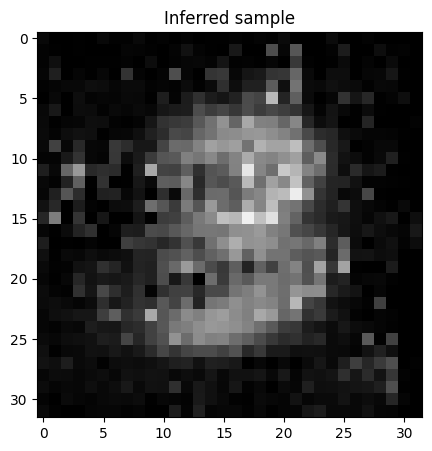

 40%|███▉      | 398/1000 [00:23<00:34, 17.44it/s, Loss=0.00017] 

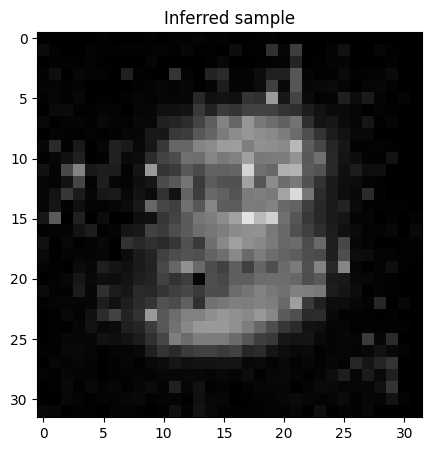

 50%|████▉     | 498/1000 [00:29<00:29, 16.86it/s, Loss=0.00598] 

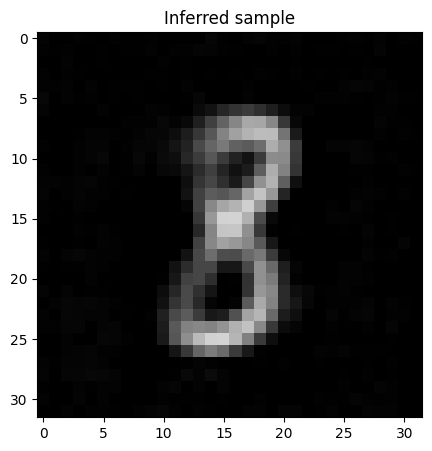

 60%|█████▉    | 598/1000 [00:35<00:23, 16.97it/s, Loss=0.0092] 

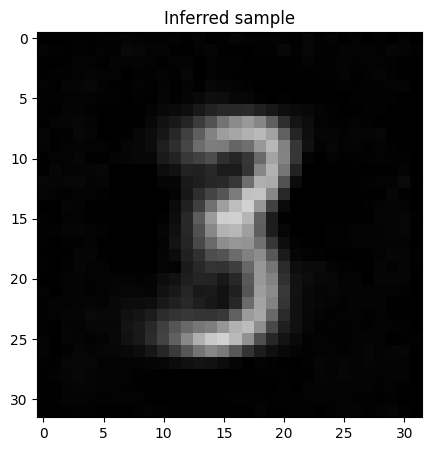

 70%|██████▉   | 698/1000 [00:41<00:17, 17.66it/s, Loss=0.00581]

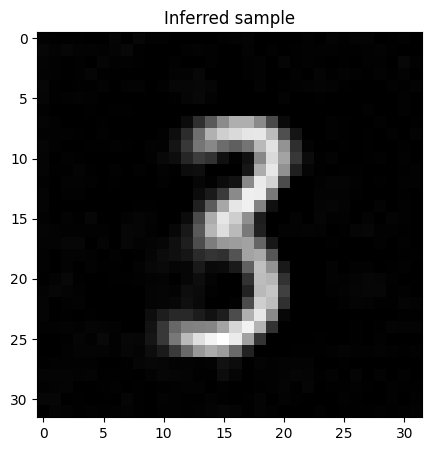

 80%|███████▉  | 798/1000 [00:47<00:12, 16.71it/s, Loss=0.0156] 

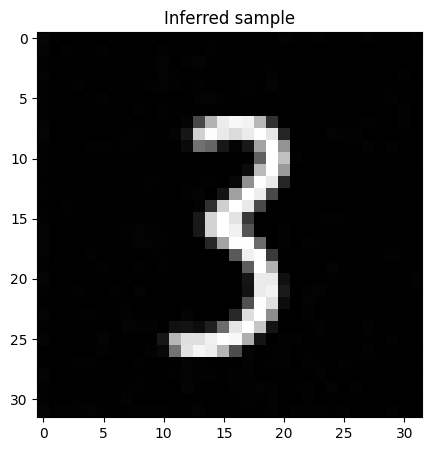

 90%|████████▉ | 898/1000 [00:53<00:05, 17.56it/s, Loss=0.0179]

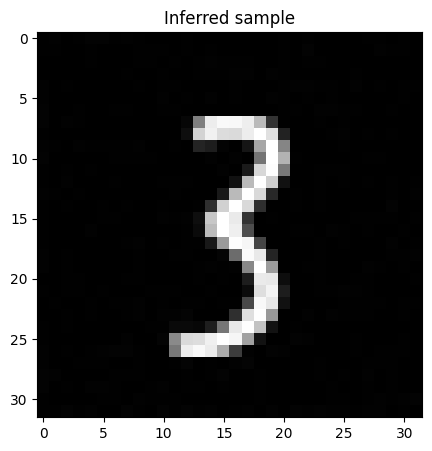

100%|█████████▉| 998/1000 [00:59<00:00, 17.94it/s, Loss=0.0229]

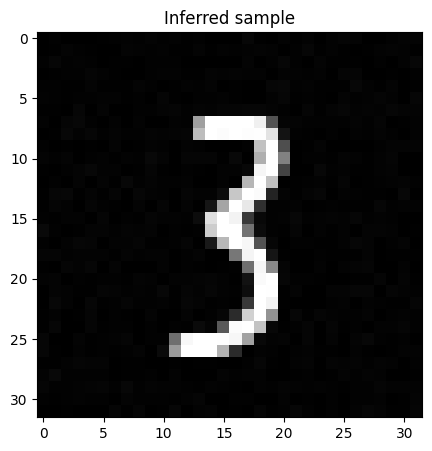

100%|██████████| 1000/1000 [00:59<00:00, 16.88it/s, Loss=0.0229]


In [35]:
# Inference Model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.img = nn.Parameter(torch.randn(1,1,32,32))
        self.img.requires_grad = True
                
    def encode(self):
        return self.img
    
model = Model().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
net.train()
class_net.train()

steps = 1000
bar = tqdm.tqdm(range(steps))
losses = []
update_every = 50
for i, _ in enumerate(bar):
    sample_img = model.encode()
   
    # Select t
    t = ((steps-i) + (steps-i)//4*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t]).astype(int)
    t = np.clip(t, 1, diffusion.T)
    
    # Denoise
    xt, epsilon = diffusion.sample(sample_img, t)       
    t = torch.from_numpy(t).float().view(sample_img.shape[0])
    epsilon_pred = net(xt.float(), t.to(device))

    # Conditions
    sample_img_clipped = torch.clip(sample_img, -1, 1)
    # Hand-crafted
    #vertical_similarity = F.mse_loss(sample_img_clipped, torchvision.transforms.functional.hflip(model.encode()))
    horizontal_similarity = F.mse_loss(sample_img_clipped, torchvision.transforms.functional.vflip(model.encode()))
    #vertical_dissimilarity = -F.mse_loss(sample_img_clipped, torchvision.transforms.functional.hflip(sample_img_clipped))
    #horizontal_dissimilarity = -F.mse_loss(sample_img_clipped, torchvision.transforms.functional.vflip(sample_img_clipped))
    # Learned
    class_loss = class_net(sample_img_clipped).mean()

    # Denoising loss + aux loss
    loss = F.mse_loss(epsilon_pred, epsilon) + 0.01*(steps-i)/steps*class_loss #+ 0.01*(steps-i)/steps*horizontal_similarity
    
    # Update
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    if i % update_every == 0:
        bar.set_postfix({'Loss': np.mean(losses)})
        losses = []

    # Visualize sample
    if (i+1) % 100 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(model.encode()[0].detach().cpu().numpy().transpose([1,2,0]), vmin=-1, vmax=1)
            ax.set_title('Inferred sample')
            plt.show()